<a href="https://colab.research.google.com/github/asim-v/COVIBOT/blob/master/PythonCrawler/%20TweeterStreamer_ExtractTweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto de Minado de Tweets


* Autor: Noé Amador Campos Castillo
* Email: ama-noe@outlook.com
* Github: NoeCampos22
* Description: Notebook hecho para minar tweets.
* Last Update: 14-Marzo-2020
* Modificación: Lista de palabras y #, 24-Feb-2020, se agregó el guardar en drive. Xochitl Morales
* Modificación: Lista de palabras y #, 14-Marzo-2020, se modifico nombre de archivo a crear, nuevas palabras a buscar y uso de coordenadas para delimitar. Ismael Peregrina

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Descargar Tweepy
Para utilizar esta notebook es necesario descargar el paquete llamado **Tweepy**.

In [0]:
!pip install tweepy

### Credenciales
Son las llaves necesarias para conectarse a la aplicación en Twitter.Recuerda tener el archivo Access.xlsx en el drive en la ruta que esta indicada abajo. Estas credenciales son unicas por persona y se solicitan directamente a Tweeter cuando se crea un development account, por lo tanto no se pueden compartir.

In [0]:
import pandas as pd
values = pd.read_excel('drive/My Drive/COVID19/Libraries/Access.xlsx', header=None)
keys = values.set_index([0]).to_dict()
keys['Twitter'] = keys.pop(1)


In [0]:
CON_KEY = keys['Twitter']['consumer_key']
CON_KEY_SECRET = keys['Twitter']['consumer_secret']
ACC_TOKEN = keys['Twitter']['access_token']
ACC_TOKEN_SECRET = keys['Twitter']['access_token_secret']

### Clase MyTweet 
Es una clase utilizada para filtrar la información dada por el objeto tweet dado por tweepy.

In [0]:
import re
import datetime


class myTweet:
    """
    A class to summarize the original Tweet object received from
    Tweepy (Twitter API for Python)
    """

    def __init__(self, ogTweet):
        """
        It is the constructor to my version of the tweet object.

        Parameters:
        - ogTweet: The tweet object.
        """

        # Get tweet data
        self.__getTweetData(ogTweet)

        # Get if it is a retweet or not
        self.__getRetweet(ogTweet)

        # Get user information
        self.__getUserData(ogTweet)

        # Get all the data from the entities
        self.__getFromEntities(ogTweet)

        # Get the place data
        self.__getFromPlace(ogTweet)

    def __getTweetData(self, ogTweet):
        """
        Private function to get data about the tweet object.

        Parameters:
        - ogTweet: The tweet object.
        """

        if ogTweet != None:
            self.tw_id_str = ogTweet['id_str']
            self.tw_truncated = ogTweet['truncated']
            self.tw_created_at = ogTweet['created_at']
            self.tw_coordinates = ogTweet['coordinates']
            self.tw_is_quote_status = ogTweet['is_quote_status']
            self.tw_in_reply_to_user_id_str = ogTweet['in_reply_to_user_id_str']
            self.tw_in_reply_to_status_id_str = ogTweet['in_reply_to_status_id_str']

            # If the text has more than 140 chars, the full text is inside
            # the extended_tweet object.
            if 'extended_tweet' in ogTweet:
                self.tw_text = ogTweet['extended_tweet']['full_text']

            else:
                self.tw_text = ogTweet['text']

    def __getRetweet(self, ogTweet):
        """
        Private function to get if the received tweet is a retweet or not.

        Parameters:
        - ogTweet: The tweet object.
        """
        if 'retweeted_status' in ogTweet:
            self.rt_isRetweet = True
            self.rt_OgTweetID = ogTweet['retweeted_status']['id_str']
            self.rt_OgRetwCount = ogTweet['retweeted_status']['retweet_count']
            self.rt_OgFavCount = ogTweet['retweeted_status']['favorite_count']
        else:
            self.rt_isRetweet = False
            self.rt_OgTweetID = ""
            self.rt_OgRetwCount = 0
            self.rt_OgFavCount = 0

    def __getUserData(self, ogTweet):
        """
        Private function to get information from the tweet's author

        Parameters:
        - ogTweet: The tweet object.
        """
        if ogTweet != None:
            # User information
            self.usr_name = ogTweet['user']['name']
            self.usr_id_str = ogTweet['user']['id_str']
            self.usr_verified = ogTweet['user']['verified']
            self.usr_location = ogTweet['user']['location']
            self.usr_screenname = ogTweet['user']['screen_name']
            self.usr_listedcount = ogTweet['user']['listed_count']
            self.usr_friendscount = ogTweet['user']['friends_count']
            self.usr_statusescount = ogTweet['user']['statuses_count']
            self.usr_followerscount = ogTweet['user']['followers_count']
            self.usr_favouritescount = ogTweet['user']['favourites_count']

    def __getFromEntities(self, ogTweet):
        """
        Private function to get the list of the hashtags, media files or urls
        that are used on the tweet

        Parameters:
        - ogTweet: The tweet object.
        """
        self.ent_urls = ""
        self.ent_media = ""
        self.ent_hashtags = ""

        if 'media' in ogTweet['entities']:
            for media in ogTweet['entities']['media']:
                self.ent_media += media['expanded_url'] + " | "

        for hasht in ogTweet['entities']['hashtags']:
            self.ent_hashtags += hasht['text'] + " | "

        for url in ogTweet['entities']['urls']:
            self.ent_urls += url['url'] + " | "

        self.ent_urls = self.ent_urls[:-3]
        self.ent_media = self.ent_media[:-3]
        self.ent_hashtags = self.ent_hashtags[:-3]

    def __getFromPlace(self, ogTweet):
        """
            Private function that checks if the tweet has information
            about the place the tweet was made from.

            Parameters:
                - ogTweet: The tweet object.
        """

        # Check if the place object exists or not and save it if so
        if ogTweet['place'] != None:
            self.geo_name = ogTweet['name']
            self.geo_country = ogTweet['country']
            self.geo_full_name = ogTweet['full_name']
            self.geo_place_type = ogTweet['place_type']
            self.geo_country_code = ogTweet['country_code']
            self.geo_bounding_box = ogTweet['bounding_box']

        else:
            self.geo_name = ""
            self.geo_country = ""
            self.geo_full_name = ""
            self.geo_place_type = ""
            self.geo_country_code = ""
            self.geo_bounding_box = {}

    def serialize(self):
        """
        It returns the object as a dictionary
        """
        return self.__dict__


### Programa de Minado
Es el script que se encarga de conectarse a la app en Twitter y empezar a minar los tweets.

Necesitamos sacar las coordenadas de un area para que funcione 
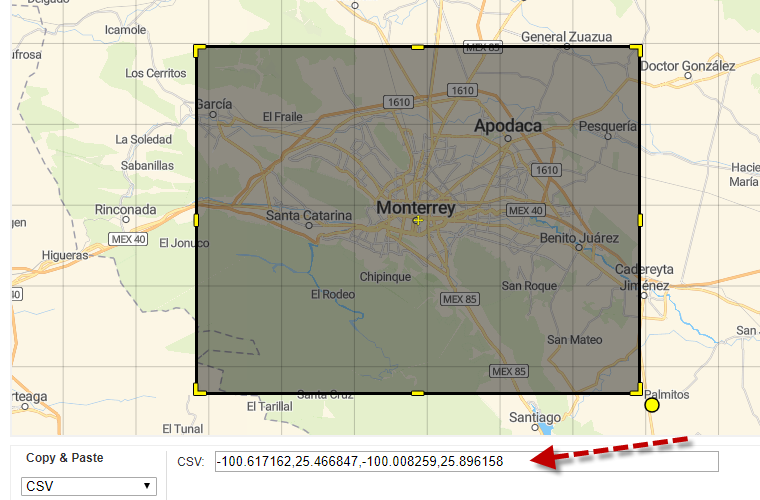

https://boundingbox.klokantech.com/

In [0]:
# Imports from the Tweepy API
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import API

# To check if the file exist
import os.path

# Another imports to parse the json
import json
import time
import csv

# Variable to store the pointer to the CSV file
FILE_MINING = None
# Variable to know if the output file already exists or not
FILE_EXISTS = False
# Variable to count how many tweets were mined
TWEETS_COUNT = 0


def Get_Authentication():
    """
    Get the authentication of the twitter app
    """

    # Validate the Credentials
    Auth = OAuthHandler(CON_KEY, CON_KEY_SECRET)
    # Validate the Acces Tokens
    Auth.set_access_token(ACC_TOKEN, ACC_TOKEN_SECRET)
    return Auth


class MyStreamListener(StreamListener):
    """
    Class in charge of getting the tweets
    """

    def on_error(self, status):
        # status 420 is a warning to stop doing this
        if status == 420:
            return False
        # Print the error status
        print(status)

    def on_data(self, data):
        try:
            # Get the global variables
            global FILE_EXISTS
            global FILE_MINING
            global TWEETS_COUNT

            # Loads the tweet object
            parsed = json.loads(data)

            # Create the tweet object with the info we need and return the json
            Tweet = myTweet(parsed).serialize()

            # Object to write a dictionary on a csv
            dictWriter = csv.DictWriter(
                FILE_MINING, fieldnames=Tweet.keys(), delimiter=',', lineterminator='\n')

            # If the file did not exists
            if not FILE_EXISTS:
                # Writes the headers
                dictWriter.writeheader()
                FILE_EXISTS = True

            # Write the dict on the file
            dictWriter.writerow(Tweet)

            # Plus one to the counter
            TWEETS_COUNT += 1

            # Print in the terminal
            if TWEETS_COUNT % 30 == 0:
                print('.')
            else:
                print('.', end=' ')

            return True

        except BaseException as e:
            print("->Error on data: %s" % str(e))   # Catch the error

        return True


if __name__ == '__main__':
    # An array with the key phrases to filter the tweets
    #keyWords = ['cortar pelo' , 'cabello ','servicios','comida'
    #            'veterinario','ayuda de limpieza','plomero','cerrajero','niñera',
    #            'carpintero','limpiar zapatos','limpiar tenis','reparaciones'
    #            ,'comidas caseras','peluquero','peluquera','electricista','climas'
    #            ,'minisplit', 'mini split', 'ayuda en casa','impermiabilizar','cerradura'
    #            ,'golpes','ginecologo','ginecologa','tiendita','cigarros','jugos','comida saludable','necesito'
    #           ]
    keyWords = ['Guantes','Cubrebocas','Cofias', 'Lentes' , 'clínicas','Seguro Social',
                'alimentos no perecederos', 'botiquín médico','doctora', 'enfermero','mircroempresas','sobrevivir a la cuarentena',
                'personal de salud','centro de acopio','adultos mayores','situacion vulnerable', 'salud mental', 'nutricion','resilencia',
                'acompañamiento','psicosocial','confinamiento en casa','tercera edad','mantenerte seguro',
                'test', 'tianguis', 'ayuda en casa','situacion de calle','violencia en casa','caretas',
                'golpes','ginecologo','ginecologa','tiendita','cigarros','jugos','comida saludable','necesito','necesidades'
               ]
    

    #Datasets = mismas catergorias que tenemos en el dataset anterior. 
    
    #keyWords = ['cerveza','medidas','costco','covid19','corona','virus']
      #         '#Tecmi',
      #        'tecmi','Tecmilenio','#tecmilenio','#tecmi'
      #          '']
    location = [-118.6,14.39,-86.49,32.72] #--> Mexico?
    #location = [-100.617162,25.466847,-100.008259,25.896158] #--> Monterrey
    filename = 'junio_09_20'

    print("====== Running App ======")
    try:
        # Start to the listen tweets
        Auth = Get_Authentication()
        myStreamListener = MyStreamListener()
        myStream = Stream(Auth, myStreamListener)

        # Check if the CSV file already exits
        if os.path.exists('TweetsExtract'+ filename +'.csv'):
            FILE_EXISTS = True

        # Open the file where the tweets are going to be write
        FILE_MINING = open('TweetsExtract'+ filename +'.csv', 'a+',
                           encoding='UTF-8', newline='')

        print("\n>> Listening tweets")

        # Filter the tweets by language (spanish) and the keywords
        myStream.filter(languages=["es"], track=keyWords, stall_warnings=True,locations=location)

    # To stop the program
    except KeyboardInterrupt:
        FILE_MINING.close()
        print("\n\n>> Mining finished.")
        print(str(TWEETS_COUNT) +
              " tweets were written in the TweetsExtract"+ filename + ".csv file")
        !cp TweetsExtract_09_20.csv "drive/My Drive/Nlu"
    except Exception as err:
        # Print if there is an error
        FILE_MINING.close()
        print("\n\n>> Mining finished.")
        print(str(TWEETS_COUNT) +
              " tweets were written in the TweetsExtract.csv file")
        !cp TweetsExtract_09_20.csv "drive/My Drive/Nlu"
        print(err)


====== Running App ======

>> Listening tweets
. . . . ->Error on data: 'name'
. . . . . ->Error on data: 'name'
. ->Error on data: 'name'
. ->Error on data: 'name'
. . . . . . . ->Error on data: 'name'
. ->Error on data: 'name'
. . . . . . . . ->Error on data: 'name'
->Error on data: 'name'
. . .
. . . . . . . . . . . . ->Error on data: 'name'
. . ->Error on data: 'name'
. ->Error on data: 'name'
->Error on data: 'name'
. . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . ->Error on data: 'name'
. . . . ->Error on data: 'name'
. ->Error on data: 'name'
.
. ->Error on data: 'name'
. . ->Error on data: 'name'
. . . . . . . . . . . . . . ->Error on data: 'name'
. . ->Error on data: 'name'
. . . . ->Error on data: 'name'
. . . . . . ->Error on data: 'name'
.
. . . ->Error on data: 'name'
. . . . . . . . . ->Error on data: 'name'
. ->Error on data: 'name'
. . . . . ->Error on data: 'name'
. . . . . ->Error on data: 'name'
. ->Error on data: 'name'
. . . . . ->Error

In [0]:
!cp TweetsExtractjunio_09_20.csv "drive/My Drive/Nlu"

In [0]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/Nlu/TweetsExtractjunio_09_20.csv')
df.count()

tw_id_str                       6546
tw_truncated                    6546
tw_created_at                   6546
tw_coordinates                     0
tw_is_quote_status              6546
tw_in_reply_to_user_id_str       718
tw_in_reply_to_status_id_str     625
tw_text                         6546
rt_isRetweet                    6546
rt_OgTweetID                    3938
rt_OgRetwCount                  6546
rt_OgFavCount                   6546
usr_name                        6546
usr_id_str                      6546
usr_verified                    6546
usr_location                    3568
usr_screenname                  6546
usr_listedcount                 6546
usr_friendscount                6546
usr_statusescount               6546
usr_followerscount              6546
usr_favouritescount             6546
ent_urls                         996
ent_media                        325
ent_hashtags                     866
geo_name                           0
geo_country                        0
g